# Dog breed classifiaction with Pytorch

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
!pip install smdebug
!pip install torch --no-cache-dir

In [2]:
import sagemaker
import boto3
import torch
import matplotlib.pyplot as plt
from sagemaker.pytorch import PyTorch
import gzip 
import random
import os
from sagemaker.session import Session
from sagemaker import get_execution_role

## Dataset
The dataset for this project is dogImages including 133 different dog breeds. 

In [3]:
sessio = sagemaker.Session()
bucket = sessio.default_bucket()
print("Default Bucket: {}".format(bucket))
region =sessio.boto_region_name
print("AWS region: {}".format(region))
role = get_execution_role()
data_directory= 'myproject3'
print("Role : {}".format(role), data_directory)

Default Bucket: sagemaker-us-east-1-896725556613
AWS region: us-east-1
Role : arn:aws:iam::896725556613:role/service-role/AmazonSageMaker-ExecutionRole-20211214T154543 myproject3


In [ ]:

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
# Fetch and upload the data to AWS S3

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/data_directory/dogImages

In [4]:
inputs= 's3://'+bucket+'/'+data_directory+'/dogImages/'
#inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-896725556613/myproject3/dogImages/


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [6]:
# Define our success metric and a regular expression for finding that metric in the training job logs.
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
#Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

In [11]:

estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    base_job_name='hpo-ResNet',
    py_version='py36',
    framework_version='1.6',
    instance_count=1,
    instance_type='ml.m5.xlarge'  
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type='Auto'
)

In [12]:
os.environ['SM_CHANNEL_TRAINING'] = 's3://'+bucket+'/'+data_directory+'/dogImages/'
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/'+data_directory+'/dogImages/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://'+bucket+'/'+data_directory+'/dogImages/output/'

In [13]:
# Fit HP Tuner
tuner.fit({'train': inputs}, wait=True)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [14]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-20 18:10:42 Starting - Preparing the instances for training
2021-12-20 18:10:42 Downloading - Downloading input data
2021-12-20 18:10:42 Training - Training image download completed. Training in progress.
2021-12-20 18:10:42 Uploading - Uploading generated training model
2021-12-20 18:10:42 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '3',
 'lr': '0.004726993511256629',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo-ResNet-2021-12-20-17-10-58-865"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-896725556613/hpo-ResNet-2021-12-20-17-10-58-865/source/sourcedir.tar.gz"'}

In [15]:
best_hpo={'batch-size': int(best_estimator.hyperparameters()['batch-size'].replace('"', "")),
          'lr': best_estimator.hyperparameters()['lr'], 
          'epoch': best_estimator.hyperparameters()['epochs'],}
print(f"The best hpo:\n {best_hpo}")

The best hpo:
 {'batch-size': 256, 'lr': '0.004726993511256629', 'epoch': '3'}


## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [16]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile, CollectionConfig, DebuggerHookConfig

# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [17]:
# Create and fit an estimator
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config = CollectionConfig(
    name='CrossEntropyLoss_output_0',
    parameters={
        'include_regex': 'CrossEntropyLoss_output_0',
        'train.save_interval': '10',
        'eval.save_interval': '1'
    }
)

debugger_hook_config = DebuggerHookConfig(
    collection_configs=[
        collection_config
    ]
)

estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge', 
    hyperparameters=best_hpo,
    framework_version='1.6',
    py_version='py36',
    env={"MMS_DEFAULT_RESPONSE_TIMEOUT": "6000"},
    profiler_config=profiler_config,
    debugger_hook_config=debugger_hook_config,
    rules=rules
)

In [18]:
estimator.fit({"train": inputs}, wait=True)


2021-12-20 19:03:07 Starting - Starting the training job...
2021-12-20 19:03:37 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2021-12-20 19:04:37 Starting - Preparing the instances for training.........
2021-12-20 19:06:06 Downloading - Downloading input data............
2021-12-20 19:08:03 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-20 19:08:12,940 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-20 19:08:12,960 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-20 19:08:19,207 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-20 19:08:19,615 sagemaker-training-toolkit INFO     Invoking user script
T

## Plot a debugging output


In [19]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job_name = estimator.latest_training_job.name
# profiling data (wait for the data to be available)
training_job = TrainingJob(training_job_name, region)
training_job.wait_for_sys_profiling_data_to_be_available()

[2021-12-20 19:17:08.751 ip-172-16-10-72:28051 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-896725556613/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/profiler-output


Profiler data from system is available


In [20]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = training_job.get_systems_metrics_reader()
# Refresh the event file list
system_metrics_reader.refresh_event_file_list()

# Plot system metrics timeline charts
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2021-12-20 19:18:20.323 ip-172-16-10-72:28051 INFO metrics_reader_base.py:134] Getting 11 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [21]:
from smdebug.trials import create_trial

# Create a Debugger trial object to access the saved model parameters
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2021-12-20 19:18:28.721 ip-172-16-10-72:28051 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/debug-output


In [22]:
# Print the default S3 bucket URI where the Debugger output tensors are stored
trial.path

's3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/debug-output/'

In [23]:
trial.tensor_names()


[2021-12-20 19:18:36.566 ip-172-16-10-72:28051 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-20 19:18:37.588 ip-172-16-10-72:28051 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [24]:
from smdebug.core.modes import ModeKeys

len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

9

In [25]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))


16

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


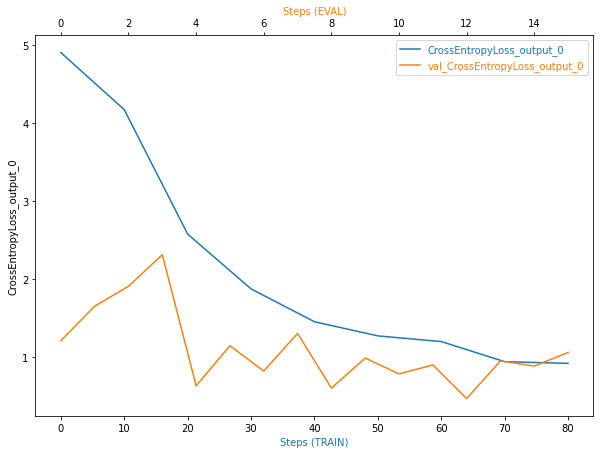

In [27]:
from smdebug.core.modes import ModeKeys
    
# Plot the curve
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [28]:

rule_output_path = estimator.output_path + estimator.latest_training_job.name + "/rule-output"
print(f"Profiler report path: {rule_output_path}")


Profiler report path: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/rule-output


In [29]:
! aws s3 ls {rule_output_path} --recursive


2021-12-20 19:16:34     396309 pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-20 19:16:33     249140 pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-20 19:16:28        192 pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-20 19:16:28      23910 pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-20 19:16:28        126 pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-20 19:16:29        340 pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-20 19:16:29       9314 pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-re

In [30]:
! aws s3 cp {rule_output_path} ./ --recursive


download: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-89672555661

In [31]:
from IPython.display import FileLink, FileLinks

# Get the profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [32]:
report_file_name = profiler_report_name + "/profiler-output/profiler-report.html"
display("Profiler report link", FileLink(report_file_name))

'Profiler report link'

/home/ec2-user/SageMaker/ProfilerReport/profiler-output/profiler-report.html

In [ ]:
# TODO: Deploy your model to an endpoint
#endpoint_name ='predict-dog-breed'
#predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge", endpoint_name=endpoint_name)


In [ ]:
# Download test image
#test_file_name = "/tmp/test.jpg"
#file_to_download = data_directory+'/'+"dogImages/test/004.Akita/Akita_00258.jpg"
#s3 = boto3.client('s3')
#s3.download_file(bucket,file_to_download, test_file_name)

# View test image
#from PIL import Image

#image = Image.open(test_file_name)
#image.show()'''


In [ ]:
#response = predictor.predict(image,initial_args={"ContentType": "image/jpeg"})

In [45]:
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )


In [50]:
# doea not work with pytorch
#predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge") 


----------!

In [62]:
# model_data = estimator.model_data

pytorch_model = PyTorchModel(model_data='s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-20-19-03-06-775/output/model.tar.gz', 
                             role=role,
                             entry_point='inference.py',
                             source_dir='code',
                             py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(instance_type='ml.m5.large', initial_instance_count=1, )

------!

get image byte


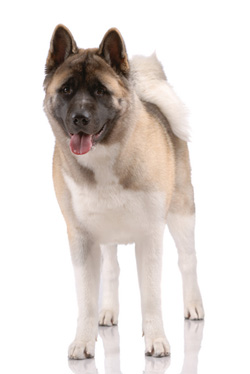

In [63]:
import io
from PIL import Image

with open("./dogImages/test/004.Akita/Akita_00270.jpg", 'rb') as f:
    image_b = f.read()
image = Image.open(io.BytesIO(image_b))
image.show()

In [65]:
response = predictor.predict(image_b, initial_args={"ContentType": "image/jpeg"})
print(response)

InternalFailure: An error occurred (InternalFailure) when calling the InvokeEndpoint operation (reached max retries: 4): An exception occurred while sending request to model. Please contact customer support regarding request a59bf791-0f02-4556-9bbb-983084511630.

In [ ]:
import torch
import numpy as np
np.argmax(response, 1)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
#predictor.delete_endpoint()
#predictor2.delete_endpoint()